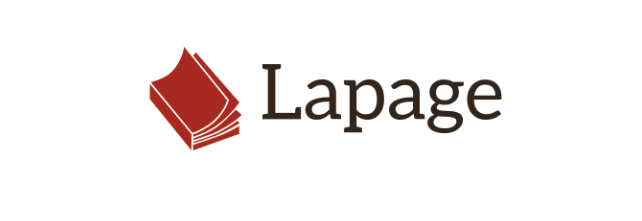

# <u> Créer un NOTEBOOK qui visera à analyser les ventes de la librairie LaPage. </u>
Le Notebook est constitué de 2 parties.
- Une analyse des différents indicateurs de vente, qui ont été demandée directement par Antoine.
- Une analyse plus ciblée sur les clients demandée par Julie : l’objectif serait cette fois-ci de comprendre le comportement de clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import anderson
from scipy import stats

In [2]:
df_cust = pd.read_csv('customers.csv')
df_prod = pd.read_csv('products.csv')
df_trans = pd.read_csv('transactions.csv')

## Exploration des données

In [3]:
df_cust.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [4]:
df_prod.describe() # Valeurs negatives, à éliminer sauf si on les vois pas après

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [5]:
df_trans.describe() #Vérifier le type de date (Vérifier aussi date qui commence par "test" et session s_0)

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


In [6]:
df_trans.sort_values(by='session_id').head()

,id_prod,date,session_id,client_id
320833,T_0,test_2021-03-01 02:30:02.237447,s_0,ct_1
561543,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_1
634523,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_0
295782,T_0,test_2021-03-01 02:30:02.237418,s_0,ct_1
237649,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1


In [7]:
df_trans.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [8]:
df_trans.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

In [9]:
df_cust.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [10]:
df_trans['date'].str.contains("test").value_counts() # les lignes avec "test"

False    679332
True        200
Name: date, dtype: int64

In [11]:
df_trans = df_trans[df_trans['date'].str.contains("test") == False] #Eliminer les lignes avec une date de 'test'

In [12]:
df_trans['date'] = pd.to_datetime(df_trans['date']) #Object à date pour les dates

In [13]:
df_prod.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


## Calculer l'âge des clients

In [14]:
year = datetime.now().year
df_cust['age'] = (year - df_cust['birth'])

In [15]:
df_t_prod = pd.merge(df_trans, df_prod, how='left', on=['id_prod'])

In [16]:
df_tpc = pd.merge(df_t_prod, df_cust, how='left', on=['client_id'])

In [17]:
df_tpc.describe() #(on a eliminé les valeurs negatives)

,price,categ,birth,age
count,679111.000000,679111.000000,679332.000000,679332.000000
mean,17.454773,0.441953,1977.811139,45.188861
std,18.328998,0.595042,13.574553,13.574553
min,0.620000,0.000000,1929.000000,19.000000
25%,8.870000,0.000000,1970.000000,36.000000
50%,13.990000,0.000000,1980.000000,43.000000
75%,18.990000,1.000000,1987.000000,53.000000
max,300.000000,2.000000,2004.000000,94.000000


In [18]:
df_tpc.info() #221 valeurs nulles de plus dans price et categ

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   price       679111 non-null  float64       
 5   categ       679111 non-null  float64       
 6   sex         679332 non-null  object        
 7   birth       679332 non-null  int64         
 8   age         679332 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 51.8+ MB


In [19]:
df_tpc[(df_tpc['price'].isnull()) & (df_tpc['categ'].isnull())] 

,id_prod,date,session_id,client_id,price,categ,sex,birth,age
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,NaN,NaN,m,1940,83
10103,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,NaN,NaN,f,1963,60
11723,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,NaN,NaN,m,1978,45
15670,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,NaN,NaN,m,1991,32
16372,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,NaN,NaN,m,1973,50
...,...,...,...,...,...,...,...,...,...
669533,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,NaN,NaN,m,1981,42
670484,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,NaN,NaN,f,1979,44
671088,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,NaN,NaN,m,1981,42
675480,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,NaN,NaN,m,1986,37


In [20]:
df_tpc.dropna(inplace=True)#Eliminer si on n'en a pas des valeurs de prix et categ (On sait que c'est catégorie 0)
df_tpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679331
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679111 non-null  object        
 1   date        679111 non-null  datetime64[ns]
 2   session_id  679111 non-null  object        
 3   client_id   679111 non-null  object        
 4   price       679111 non-null  float64       
 5   categ       679111 non-null  float64       
 6   sex         679111 non-null  object        
 7   birth       679111 non-null  int64         
 8   age         679111 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 51.8+ MB


In [21]:
df_tpc.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,f,1986,37
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,15.99,1.0,m,1988,35
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,7.99,0.0,f,1968,55
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,69.99,2.0,m,2000,23
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,4.99,0.0,m,1980,43


In [22]:
df_tpc['categ'] = df_tpc["categ"].astype(int) 

In [23]:
df_tpc.groupby(df_tpc.date.dt.month)['price'].sum() #par mois tous ans confondus

date
1     1042879.54
2      992251.26
3      997897.14
4      969108.24
5     1010076.07
6      980104.68
7      993618.52
8      988752.06
9     1001355.21
10     828716.51
11    1012832.67
12    1036136.78
Name: price, dtype: float64

In [24]:
df_ca = df_tpc.groupby(df_tpc['date'].dt.to_period('W'))['price'].sum() #Par semaine
df_ca = pd.DataFrame(df_ca)
df_ca = df_ca.rename(columns = {'price':"Chiffre d'affaires"})

In [25]:
df_ca.head()

,Chiffre d'affaires
date,
2021-03-01/2021-03-07,110463.28
2021-03-08/2021-03-14,105693.24
2021-03-15/2021-03-21,112059.08
2021-03-22/2021-03-28,109441.07
2021-03-29/2021-04-04,107895.66


In [26]:
df_ca.dtypes

Chiffre d'affaires    float64
dtype: object

In [27]:
df_ca['Moyenne Mobile'] = df_ca["Chiffre d'affaires" ].rolling(8).mean() #Moyenne mobile on peut varier le range
df_ca.dropna(inplace=True)
df_ca.head()

,Chiffre d'affaires,Moyenne Mobile
date,,
2021-04-19/2021-04-25,112798.95,109883.00625
2021-04-26/2021-05-02,110675.79,109909.57000
2021-05-03/2021-05-09,115403.87,111123.39875
2021-05-10/2021-05-16,109169.44,110762.19375
2021-05-17/2021-05-23,108816.77,110684.15625


## 1_Evolution CA et sa moyenne Mobile

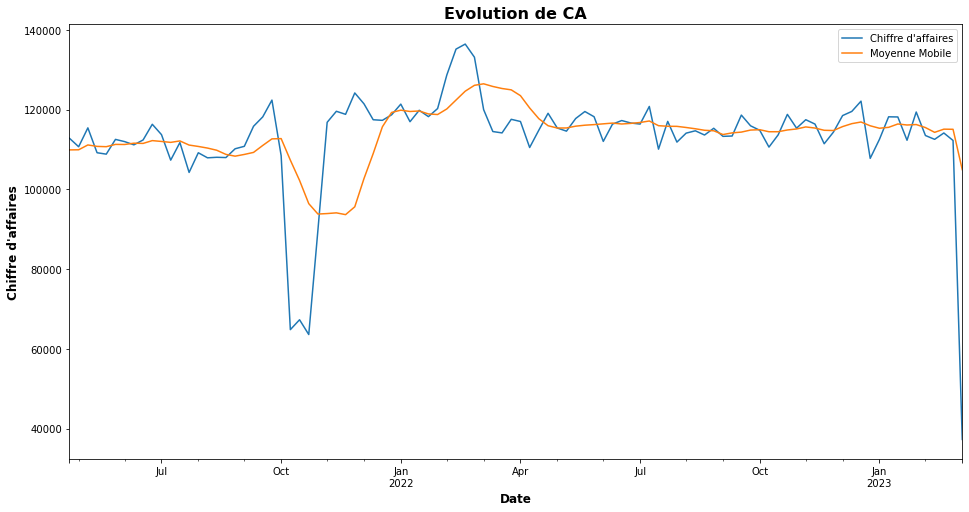

In [28]:
df_ca[["Chiffre d'affaires", 'Moyenne Mobile']].plot(label="Date", figsize=(16, 8))
plt.title('Evolution de CA', fontsize=16, y=1, weight='bold')
plt.ylabel("Chiffre d'affaires",fontsize=12, weight='bold')
plt.xlabel('Date',fontsize=12, weight='bold')
plt.show()

In [29]:
#Voir le mois d'octobre 2021 avec une CA moins importante que le reste
#dernières semaines on peut les enlever pour ne pas montrer une baisse de CA

In [30]:
## ????? Requete de Antoine: 
# Il serait également intéressant de faire un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.

## 2_Evolution de CA par categorie

In [31]:
df_tpc.groupby(by=df_tpc['categ'])['price'].sum()

categ
0    4419730.97
1    4653722.69
2    2780275.02
Name: price, dtype: float64

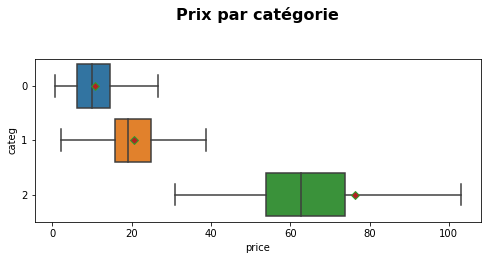

In [32]:
# Distribution et moyenne des prix par catégorie
plt.figure(figsize=(8,3))
sns.boxplot(data=df_tpc, y='categ', x='price', orient='h', showfliers=False, showmeans=True, meanprops={"marker":"D","markerfacecolor":"firebrick"})
plt.title('Prix par catégorie', fontsize=16, y=1.2, weight='bold')
plt.show()

In [33]:
prix_moyen_categ = df_tpc.groupby(['categ']).price.mean()
for i in [0, 1, 2]:
    print(f'Le prix moyen de la catégorie {i} est :', round(prix_moyen_categ[i], 2), "€")

Le prix moyen de la catégorie 0 est : 10.64 €
Le prix moyen de la catégorie 1 est : 20.49 €
Le prix moyen de la catégorie 2 est : 76.21 €


In [34]:
df_ca_date = pd.DataFrame(df_tpc.groupby([df_tpc['date'].dt.to_period('W'),'categ'])['price'].sum())

In [35]:
df_ca_date.head()

price
date                  categ          
2021-03-01/2021-03-07 0      43832.65
                      1      42774.98
                      2      23855.65
2021-03-08/2021-03-14 0      44167.01
                      1      40491.84

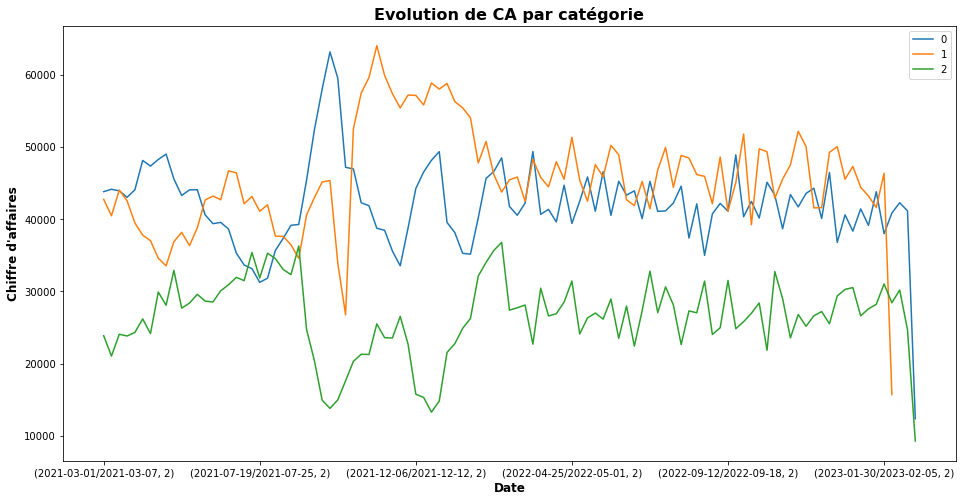

In [36]:
df_ca_date.groupby('categ')['price'].plot(legend=True, figsize=(16, 8))
plt.title('Evolution de CA par catégorie', fontsize=16, y=1, weight='bold')
plt.ylabel("Chiffre d'affaires",fontsize=12, weight='bold')
plt.xlabel('Date',fontsize=12, weight='bold')
plt.show()

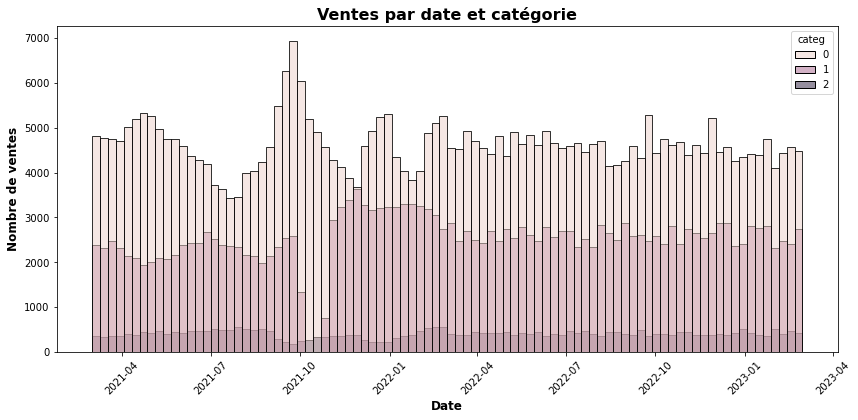

In [37]:
plt.figure(figsize=(14,6)) #pas de ventes de catégorie 1 pendant des semaines de Octobre 2021
sns.histplot(data=df_tpc, x='date', hue='categ')
plt.xticks(rotation=45)
plt.title('Ventes par date et catégorie', fontsize=16, y=1, weight='bold')
plt.ylabel("Nombre de ventes",fontsize=12, weight='bold')
plt.xlabel('Date',fontsize=12, weight='bold')
plt.show()

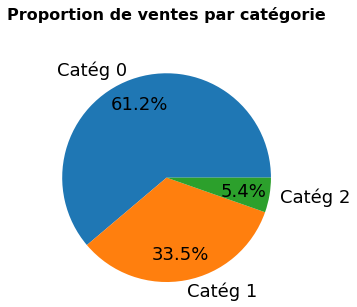

In [38]:
labels = ['Catég 0', 'Catég 1', 'Catég 2']
df_tpc.groupby('categ').size().plot(kind='pie', labels=labels, autopct='%.1f%%', pctdistance=0.75, textprops={'fontsize': 18}, radius=1.2)
plt.title("Proportion de ventes par catégorie", fontsize=16, y=1.2, weight='bold')
plt.legend('', frameon=False)
plt.ylabel('')
plt.show()

## Les produits les plus vendus (Best Sellers)

In [39]:
# Produits les plus vendus toutes categories confondues
df_pp = df_tpc.groupby(['id_prod', 'categ']).count()
df_pp.reset_index(inplace=True)
df_pp.rename(columns = {'date':'Ventes'}, inplace=True)
df_pp = df_pp.sort_values(by='Ventes', ascending=False)

In [40]:
# Produits les plus vendus toutes categories (le plus vendu par categorie)
df_pp = df_pp[['id_prod', 'categ', 'Ventes']]
df_pp = df_pp.groupby(by=['categ']).nth(0)

df_pp

,id_prod,Ventes
categ,,
0,0_1422,1292
1,1_369,2252
2,2_102,1027


In [41]:
#Enfin, j’aimerais avoir quelques informations sur les profils de nos clients, 
#et également la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz. ???
#Après, toutes les informations et tous graphiques qui apporteraient de l’information pertinente sont les bienvenus !

In [42]:
#Une analyse des différents indicateurs de vente, qui a été demandée directement par Antoine. Je t’ai mis en pièce jointe l’e-mail qu’il m’a envoyé résumant ses demandes.
#Une analyse plus ciblée sur les clients : l’objectif serait cette fois-ci de comprendre le comportement de nos clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques. Pour cela, je t’invite à voir avec Julie, qui te précisera directement ses demandes à ce niveau.

In [43]:
df_conso = df_tpc.groupby(['client_id'])['price'].sum().reset_index()

In [44]:
df_conso.sort_values(by='price',ascending=False).head(10) # 4 Clients pro?
df_conso.rename(columns = {'price':"Chiffre d'affaires"}, inplace= True)
df_conso.head(10)

,client_id,Chiffre d'affaires
0,c_1,558.18
1,c_10,1353.60
2,c_100,254.85
3,c_1000,2261.89
4,c_1001,1812.86
5,c_1002,415.78
6,c_1003,1209.84
7,c_1004,1016.30
8,c_1005,844.93
9,c_1006,3982.01


## Les clients pro

In [45]:
df_conso['Pourcentage'] = round((df_conso["Chiffre d'affaires"])/(df_conso["Chiffre d'affaires"].sum())*100, 2)
df_conso.sort_values(by='Pourcentage', ascending=False).head()

,client_id,Chiffre d'affaires,Pourcentage
677,c_1609,324033.35,2.73
4388,c_4958,289760.34,2.44
6337,c_6714,153598.92,1.30
2724,c_3454,113637.93,0.96
268,c_1240,4225.63,0.04


In [46]:
df_pro = df_tpc.loc[(df_tpc['client_id']=="c_1609")|(df_tpc['client_id']=="c_4958")|(df_tpc['client_id']=="c_6714")|(df_tpc['client_id']=="c_3454")]
df_pro.sort_values(by='client_id')

,id_prod,date,session_id,client_id,price,categ,sex,birth,age
679314,0_1160,2021-11-09 21:41:41.807534,s_117240,c_1609,17.87,0,m,1980,43
338056,1_126,2022-06-30 16:57:20.135907,s_231529,c_1609,18.60,1,m,1980,43
612064,0_1440,2022-05-11 03:54:06.362037,s_206756,c_1609,5.62,0,m,1980,43
337975,1_441,2022-07-29 22:56:07.922895,s_245618,c_1609,24.99,1,m,1980,43
337953,0_1246,2022-01-28 14:11:35.948557,s_156458,c_1609,7.01,0,m,1980,43
...,...,...,...,...,...,...,...,...,...
378897,1_367,2021-03-03 07:58:34.566989,s_1106,c_6714,13.99,1,f,1968,55
378909,1_488,2021-05-17 19:35:55.016796,s_35869,c_6714,12.19,1,f,1968,55
378977,1_299,2021-06-25 06:34:04.510333,s_53455,c_6714,13.99,1,f,1968,55
377999,1_250,2021-06-10 04:27:04.690191,s_46568,c_6714,20.76,1,f,1968,55


In [47]:
df_pro_pt = pd.pivot_table(df_pro, values='price', index=['client_id', 'categ'])
df_pro_pt

price
client_id categ            
c_1609    0       10.633572
          1       20.354972
          2      136.473636
c_3454    0       10.671001
          1       20.612335
          2       70.845556
c_4958    0       12.190000
          1       20.855530
          2       75.790596
c_6714    0       10.782409
          1       20.528739
          2       76.230330

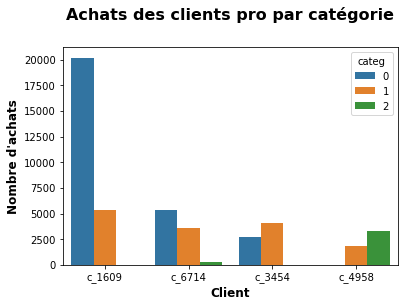

In [48]:
sns.countplot(data=df_pro, x='client_id', hue='categ', order = df_pro['client_id'].value_counts().index)
plt.title('Achats des clients pro par catégorie', fontsize=16, y=1.1, weight='bold')
plt.ylabel("Nombre d'achats",fontsize=12, weight='bold')
plt.xlabel('Client',fontsize=12, weight='bold')
plt.show()

In [49]:
df_age = pd.merge(df_conso, df_cust, how='left', on=['client_id'])
df_age

,client_id,Chiffre d'affaires,Pourcentage,sex,birth,age
0,c_1,558.18,0.00,m,1955,68
1,c_10,1353.60,0.01,m,1956,67
2,c_100,254.85,0.00,m,1992,31
3,c_1000,2261.89,0.02,f,1966,57
4,c_1001,1812.86,0.02,m,1982,41
...,...,...,...,...,...,...
8595,c_995,189.41,0.00,m,1955,68
8596,c_996,1625.58,0.01,f,1970,53
8597,c_997,1490.01,0.01,f,1994,29
8598,c_998,2779.88,0.02,m,2001,22


In [50]:
df_tpc['date_fixe'] = df_tpc['date'].dt.date 
df_tpc = df_tpc.merge(df_tpc.groupby('client_id').count()['date'].reset_index().rename(columns={'date': 'total_ventes'}), how='left', on='client_id')
df_tpc['ventes_mensuelles'] = round(df_tpc['total_ventes'] / 12)
df_tpc.sort_values(by='client_id')

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,date_fixe,total_ventes,ventes_mensuelles
449848,0_1571,2022-07-01 01:47:04.355850,s_231729,c_1,5.99,0,m,1955,68,2022-07-01,39,3.0
542680,0_1547,2022-05-08 08:27:49.586711,s_205377,c_1,8.99,0,m,1955,68,2022-05-08,39,3.0
169172,0_1475,2022-06-27 10:30:00.293075,s_230001,c_1,11.99,0,m,1955,68,2022-06-27,39,3.0
318801,0_1880,2021-11-04 18:37:01.482109,s_114737,c_1,14.91,0,m,1955,68,2021-11-04,39,3.0
583828,0_1090,2021-12-19 02:44:12.827475,s_136532,c_1,13.78,0,m,1955,68,2021-12-19,39,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
308937,0_1442,2023-01-28 13:12:42.429052,s_333631,c_999,4.89,0,m,1964,59,2023-01-28,46,4.0
235560,1_395,2021-08-23 16:44:27.072834,s_79695,c_999,28.99,1,m,1964,59,2021-08-23,46,4.0
92930,0_1426,2021-09-10 02:44:13.556163,s_87567,c_999,13.44,0,m,1964,59,2021-09-10,46,4.0
385190,0_2104,2021-10-02 20:31:58.645109,s_99070,c_999,7.98,0,m,1964,59,2021-10-02,46,4.0


In [51]:
df_tpc.describe()

,price,categ,birth,age,total_ventes,ventes_mensuelles
count,679111.000000,679111.000000,679111.000000,679111.000000,679111.000000,679111.000000
mean,17.454773,0.441953,1977.811149,45.188851,1314.735478,109.560590
std,18.328998,0.595042,13.575361,13.575361,4947.838568,412.316528
min,0.620000,0.000000,1929.000000,19.000000,1.000000,0.000000
25%,8.870000,0.000000,1970.000000,36.000000,65.000000,5.000000
50%,13.990000,0.000000,1980.000000,43.000000,123.000000,10.000000
75%,18.990000,1.000000,1987.000000,53.000000,224.000000,19.000000
max,300.000000,2.000000,2004.000000,94.000000,25488.000000,2124.000000


In [52]:
df_cli = pd.merge(df_age, df_tpc[['client_id','total_ventes','ventes_mensuelles']], how='left', on=['client_id'])
df_cli['panier_moyen']=round((df_cli["Chiffre d'affaires"]/df_cli['total_ventes']),2)
df_cli.drop_duplicates(inplace=True)

In [53]:
df_par = df_cli.drop(df_cli[(df_cli['client_id']=="c_1609")|(df_cli['client_id']=="c_4958")|(df_cli['client_id']=="c_6714")|(df_cli['client_id']=="c_3454")].index)
df_par.head()

,client_id,Chiffre d'affaires,Pourcentage,sex,birth,age,total_ventes,ventes_mensuelles,panier_moyen
0,c_1,558.18,0.00,m,1955,68,39,3.0,14.31
39,c_10,1353.60,0.01,m,1956,67,58,5.0,23.34
97,c_100,254.85,0.00,m,1992,31,8,1.0,31.86
105,c_1000,2261.89,0.02,f,1966,57,125,10.0,18.10
230,c_1001,1812.86,0.02,m,1982,41,102,8.0,17.77


In [54]:
df_conso.dtypes

client_id              object
Chiffre d'affaires    float64
Pourcentage           float64
dtype: object

## Courbe de Lorenz et Indice de Gini

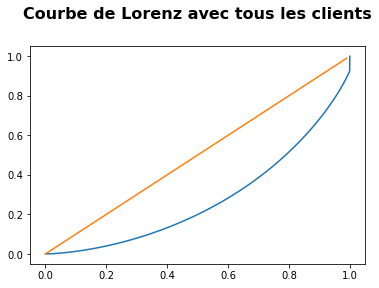

Indice de Gini : 0.44638654137401435


In [55]:
depenses = df_cli[df_cli["Chiffre d'affaires"] > 0]
dep = depenses["Chiffre d'affaires"].values
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
a = np.arange(0,1,.01)
x = a
y = a  
sns.lineplot(x=x,y=y)
plt.title('Courbe de Lorenz avec tous les clients', fontsize=16, y=1.1, weight='bold')
plt.show()
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz(Area Under the Curve). Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # Surface entre la première bissectrice et la courbe de Lorenz
gini = 2*S
print('Indice de Gini :', gini)

L'indice es plus proche de 0 si la distribution est equilibré, plus proche de 1, plus inegalitaire est la distribution de dépenses.

## Courbe de Lorenz et Indice de Gini sans les comptes pro

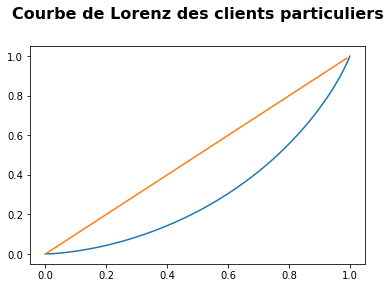

Indice de Gini : 0.40261686549497766


In [56]:
depenses = df_par[df_par["Chiffre d'affaires"] > 0]
dep = depenses["Chiffre d'affaires"].values
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
a = np.arange(0,1,.01)
x = a
y = a  
sns.lineplot(x=x,y=y)
plt.title('Courbe de Lorenz des clients particuliers', fontsize=16, y=1.1, weight='bold')
plt.show()
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz(Area Under the Curve). Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # Surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print('Indice de Gini :', gini)

-le lien entre le genre d’un client et les catégories des livres achetés ; (X2?)

-et ensuite le lien entre l’âge des clients et le montant total des achats(Student?), la fréquence d’achat, la taille du panier moyen et les catégories des livres achetés.


## Requêtes Julie

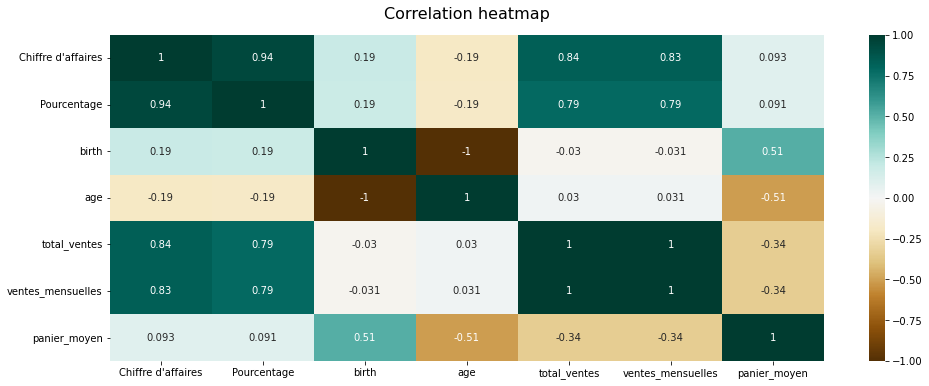

In [57]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(df_par.corr(), ax=ax, annot=True, cmap='BrBG')
plt.title('Correlation heatmap', fontdict={'fontsize':16}, pad=16)
plt.show()

### Catégorie et sexe (X^2)

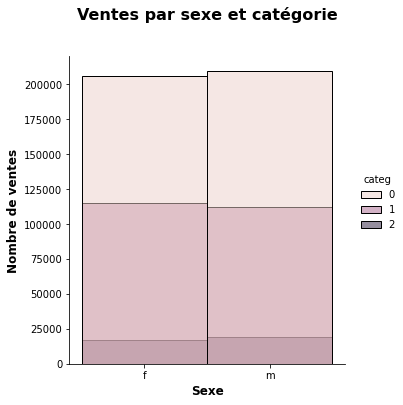

In [58]:
sns.displot(data=df_tpc, x='sex', hue='categ')
plt.title('Ventes par sexe et catégorie', fontsize=16, y=1.1, weight='bold')
plt.ylabel("Nombre de ventes",fontsize=12, weight='bold')
plt.xlabel('Sexe',fontsize=12, weight='bold')
plt.show()

In [59]:
df_count = pd.crosstab(df_tpc.categ, df_tpc.sex , margins=False)
df_count #Tableau de contingence

sex,f,m
categ,,
0,206103,209356
1,114899,112270
2,17283,19200


On pose les hypothèses de départ :

H0 : Variables indépendantes si p-value > 5%

H1 : Variables non indépendantes si p-value < 5%

In [60]:
from scipy.stats import chi2_contingency
Khi2_obs, p_value, ddl, effectif_theorique = chi2_contingency(df_count)
print(f"Le p-value est de {p_value} donc on peut rejeter l'hypothèse H0, alors on voit une dépendence de ces variables.")

Le p-value est de 1.13109805970906e-32 donc on peut rejeter l'hypothèse H0, alors on voit une dépendence de ces variables.


### Âge des clients et le montant total des achats (ANOVA ou Kruskal-Wallis Test)

In [61]:
myNom = df_par['age']
myScale = df_par["Chiffre d'affaires"]

myCat1 = myNom <= 31
myCat2 = myNom.between(32,51)
myCat3 = myNom >=52

myCatScores1 =myScale[myCat1].dropna()
myCatScores2 =myScale[myCat2].dropna()
myCatScores3 =myScale[myCat3].dropna()
stat, p =f_oneway(myCatScores1, myCatScores2, myCatScores3)  #ANOVA test si distribution normale
if p > .05:
    print('H0: Les moyennes des groupes son égales')
else:
    print('H1: Une ou plusieurs des moyennes des échantillons sont inégales')

H1: Une ou plusieurs des moyennes des échantillons sont inégales


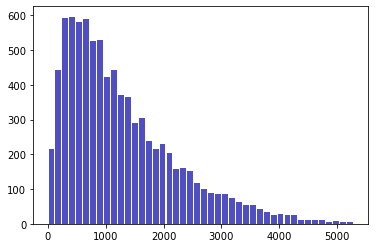

In [62]:
plt.hist(x=df_par["Chiffre d'affaires"], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

In [63]:
anderson(df_par["Chiffre d'affaires"], dist='norm') #Normality test

AndersonResult(statistic=228.62716588492185, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Non-paramétrique (les données ne suivent pas une distribution normale)

In [64]:
stat, p =st.kruskal(myCatScores1 , myCatScores2, myCatScores3) #Kruskal-Wallis Test pour variables non-paramétriques
if p > .05:
    print('H0: Les moyennes des groupes son égales')
else:
    print('H1: Une ou plusieurs des moyennes des échantillons sont inégales')

H1: Une ou plusieurs des moyennes des échantillons sont inégales


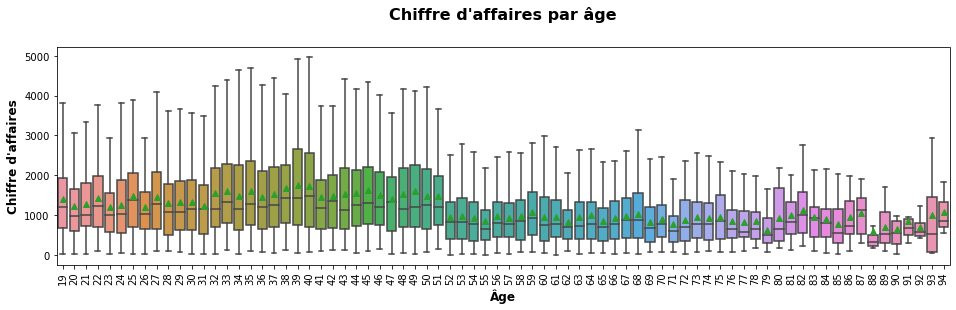

In [65]:
plt.figure(figsize=(16,4))
sns.boxplot(
    data=df_par.pivot_table(index=['client_id']),
    y="Chiffre d'affaires", x='age', showfliers=False, showmeans=True)
plt.xticks(rotation=90)
plt.title("Chiffre d'affaires par âge", fontsize=16, y=1.1, weight='bold')
plt.ylabel("Chiffre d'affaires",fontsize=12, weight='bold')
plt.xlabel('Âge',fontsize=12, weight='bold')
plt.show()

H1: Une ou plusieurs des moyennes des échantillons sont inégales. (p> 0.05)

### Âge et la fréquence d’achat (Kruskal-Wallis Test)

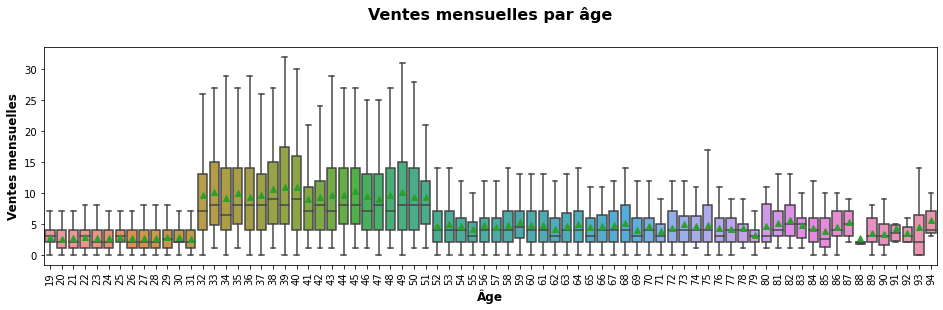

In [66]:
plt.figure(figsize=(16,4))
sns.boxplot(
    data=df_par.pivot_table(index=['client_id']),
    y='ventes_mensuelles', x='age', showfliers=False, showmeans=True)
plt.xticks(rotation=90)
plt.title('Ventes mensuelles par âge', fontsize=16, y=1.1, weight='bold')
plt.ylabel("Ventes mensuelles",fontsize=12, weight='bold')
plt.xlabel('Âge',fontsize=12, weight='bold')
plt.show()

In [67]:
anderson(df_par["ventes_mensuelles"], dist='norm') #Normality test

AndersonResult(statistic=486.31821770831266, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Non-paramétrique (les données ne suivent pas une distribution normale)

In [68]:
myNom = df_par['age']
myScale = df_par["ventes_mensuelles"]

myCat1 = myNom <= 31
myCat2 = myNom.between(32,51)
myCat3 = myNom >=52

myCatScores1 =myScale[myCat1].dropna()
myCatScores2 =myScale[myCat2].dropna()
myCatScores3 =myScale[myCat3].dropna()
stat, p = st.kruskal(myCatScores1 , myCatScores2, myCatScores3) #Kruskal-Wallis Test pour variables non-paramétriques
if p > .05:
    print('H0: Les moyennes des groupes son égales')
else:
    print('H1: Une ou plusieurs des moyennes des échantillons sont inégales')

H1: Une ou plusieurs des moyennes des échantillons sont inégales


### Âge et la taille du panier moyen (Kruskal-Wallis Test)

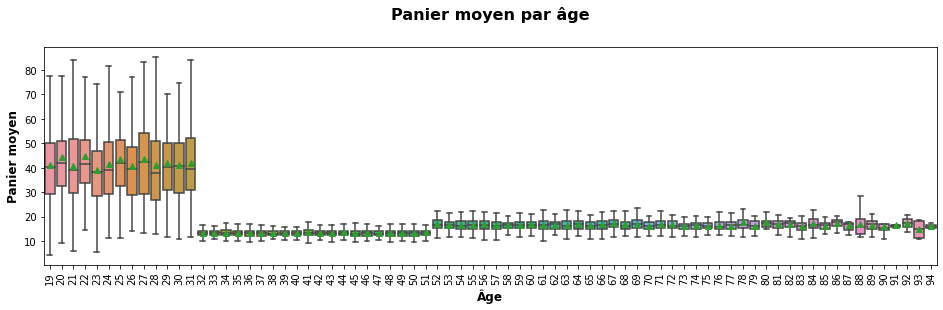

In [69]:
plt.figure(figsize=(16,4))
sns.boxplot(
    data=df_par.pivot_table(index=['client_id']),
    y='panier_moyen', x='age', showfliers=False, showmeans=True)
plt.xticks(rotation=90)
plt.title('Panier moyen par âge', fontsize=16, y=1.1, weight='bold')
plt.ylabel("Panier moyen",fontsize=12, weight='bold')
plt.xlabel('Âge',fontsize=12, weight='bold')
plt.show()

In [70]:
anderson(df_par["panier_moyen"], dist='norm') #Normality test

AndersonResult(statistic=1003.066654996097, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Non-paramétrique (les données ne suivent pas une distribution normale)

In [71]:
myNom = df_par['age']
myScale = df_par["panier_moyen"]

myCat1 = myNom <= 31
myCat2 = myNom.between(32,51)
myCat3 = myNom >=52

myCatScores1 =myScale[myCat1].dropna()
myCatScores2 =myScale[myCat2].dropna()
myCatScores3 =myScale[myCat3].dropna()
stat, p = st.kruskal(myCatScores1 , myCatScores2, myCatScores3) #Kruskal-Wallis Test pour variables non-paramétriques
if p > .05:
    print('H0: Les moyennes des groupes son égales')
else:
    print('H1: Une ou plusieurs des moyennes des échantillons sont inégales')

H1: Une ou plusieurs des moyennes des échantillons sont inégales


### Catégorie et âge (Kruskal-Wallis Test)

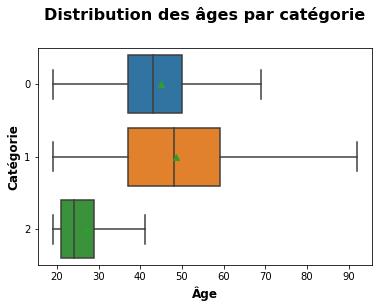

In [72]:
sns.boxplot(data=df_tpc, x='age', y='categ', orient='h', showfliers=False, showmeans=True)
plt.title('Distribution des âges par catégorie', fontsize=16, y=1.1, weight='bold')
plt.ylabel("Catégorie",fontsize=12, weight='bold')
plt.xlabel('Âge',fontsize=12, weight='bold')
plt.show()

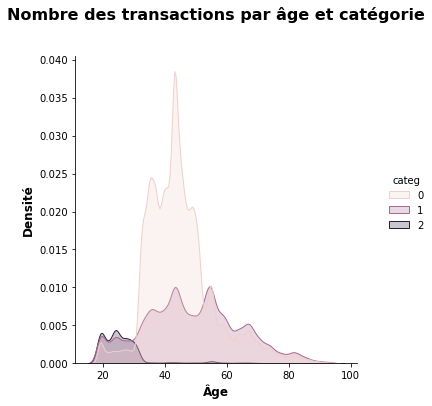

In [73]:
sns.displot(data=df_tpc, x='age', hue='categ', kind='kde', fill=True)
plt.title('Nombre des transactions par âge et catégorie', fontsize=16, y=1.1, weight='bold')
plt.ylabel("Densité",fontsize=12, weight='bold')
plt.xlabel('Âge',fontsize=12, weight='bold')
plt.show()

In [74]:
anderson(df_par["age"], dist='norm') #Normality test

AndersonResult(statistic=53.76347105611603, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Non-paramétrique (les données ne suivent pas une distribution normale)

In [75]:
myNom = df_tpc['age']
myScale = df_tpc["categ"]

myCat1 = myNom <= 31
myCat2 = myNom.between(32,51)
myCat3 = myNom >=52

myCatScores1 =myScale[myCat1].dropna()
myCatScores2 =myScale[myCat2].dropna()
myCatScores3 =myScale[myCat3].dropna()
stat, p = st.kruskal(myCatScores1 , myCatScores2, myCatScores3) #Kruskal-Wallis Test pour variables non-paramétriques
if p > .05:
    print('H0: Les moyennes des groupes son égales')
else:
    print('H1: Une ou plusieurs des moyennes des échantillons sont inégales')

H1: Une ou plusieurs des moyennes des échantillons sont inégales
